# Loading The Model and Packages

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
from KernelLogistic import KernelLogisticRegression
plt.style.use('seaborn-v0_8-whitegrid')

# Implementation

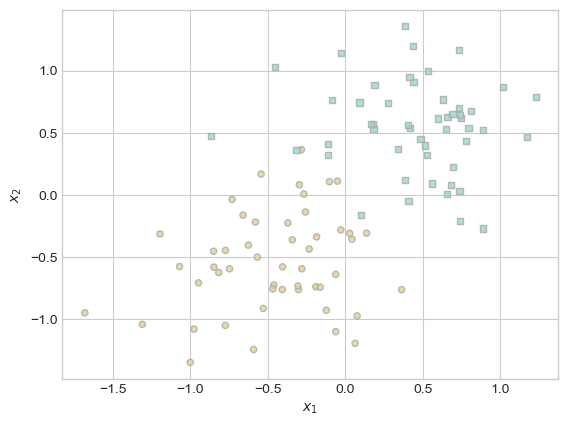

In [2]:
# Define a function to generate classification data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

# Define a function to plot the classification data
def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# Generate and plot roughly linearly separable data
fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

From the plot, it is clear that it this data is on the edge between linearly separable and linearly inseparable. Lets explore how Sparse Kernel Logistic Regression is able to classify these data points.

In [22]:
# first lets define a standard kernel
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

# instantiate a model with the given kernel and random parameters
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

Let's inspect the entries of the model weight vector to see if they have remained close to zero even after training.

In [23]:
# look at the mean of the weight vecctors
print("The mean of the weight vector a is: " + str(KR.a.mean().item()))
print("The number of entries in a is: " + str(len(KR.a)))

The mean of the weight vector a is: 1.2202486686874181e-05
The number of entries in a is: 100


Thus, across 100 entries in a the mean weight vector value is remarkably close to 0. Thus, our Sparse Kernel Logisitic Regression has maintained the property that many entries are equal to or close to zero. Lets plot the scores along with the training data. 

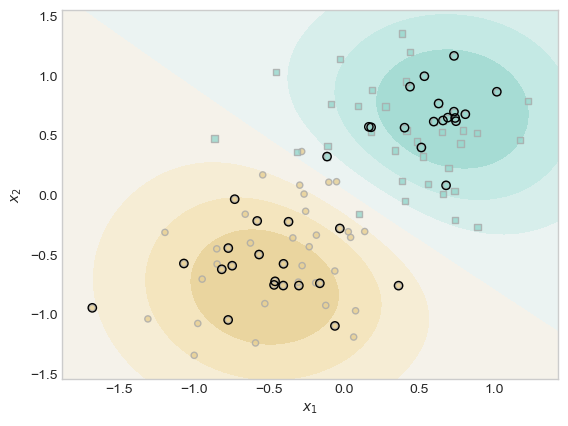

In [ ]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

This plot highlights that there are sparse points in the traiing data that have a weights distinguishable from zero, highlighted in black.

# Experiments

Lets explore how the size of lambda effects the outcome of the model, especially with respect to weight sizes. 

In [25]:
# instantiate a model with the given kernel and an unreasonably large lambda
KR = KernelLogisticRegression(rbf_kernel, lam = 1000, gamma = 1)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

Let's inspect the entries of the model weight vector to see if they have remained close to zero even after training.

In [26]:
# look at the mean of the weight vecctors
print("The mean of the weight vector a is: " + str(KR.a.mean().item()))
print("The number of entries in a is: " + str(len(KR.a)))

The mean of the weight vector a is: 0.009166927076876163
The number of entries in a is: 100


While the weight vectors have remained very close to 0, they are noticabely larger for a large lambda than they were for a smaller lambda. Lets visualize the new decision region to determine how the large lambda affects the distinguishability of weight vectors from zero.

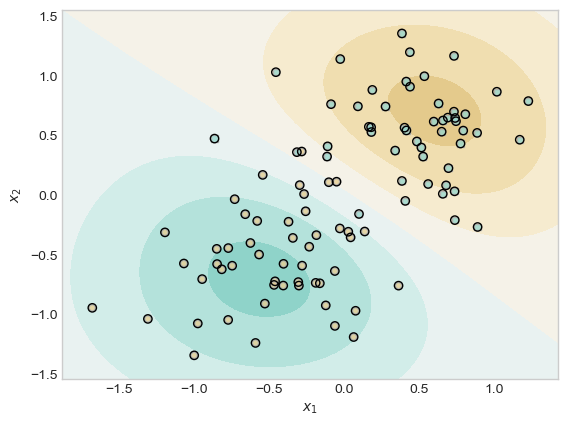

In [ ]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

A larger lambda seems to have increased the number of weight vectors which are distinguisable from 0 by a large amount, in fact, it seems that every point now has a weight distinguishable from zero. Lets now try an unnusually small lambda. 

In [28]:
# instantiate a model with the given kernel and an unreasonably small lambda
KR = KernelLogisticRegression(rbf_kernel, lam = .00001, gamma = 1)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

In [29]:
# look at the mean of the weight vecctors
print("The mean of the weight vector a is: " + str(KR.a.mean().item()))
print("The number of entries in a is: " + str(len(KR.a)))

The mean of the weight vector a is: 0.00044106869609095156
The number of entries in a is: 100


While the weight vectors have remained very close to 0, they are noticabely larger for an extremely small lambda than they were for a normal lambda. Lets visualize the new decision region to determine how the extremely small lambda affects the distinguishability of weight vectors from zero.

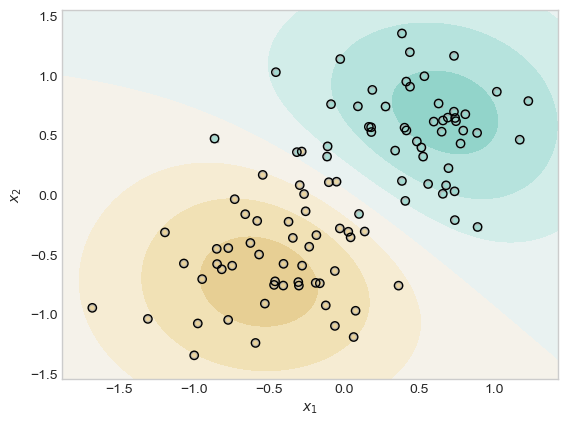

In [ ]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

Similar toa  larger lambda, an extremely small lambda seems to have increased the number of weight vectors which are distinguisable from 0 by a large amount, in fact, it seems that every point now has a weight distinguishable from zero. Now, lets examine how gamma can affect the shape of the decision boundaries. 

In [33]:
# instantiate a model with the given kernel and a larger gamma
KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 10)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

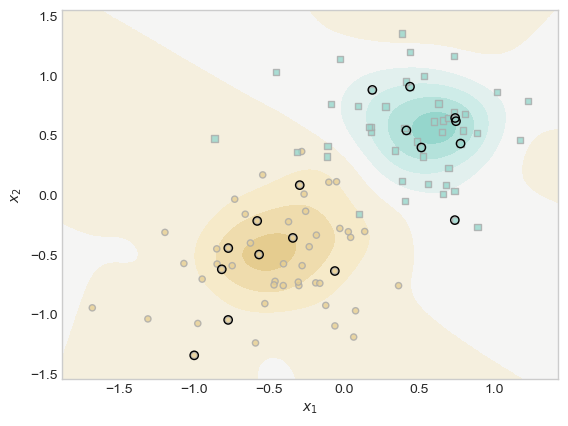

In [34]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

As visualized by the plot, the decision regions have been altered drastically simply by increasing gamma by a factor of 10. The decision boundaries are much different in size and shape, and have less smooth edges. Lets now see what happends if we decrease gamma by a factor of 10. 

In [35]:
# instantiate a model with the given kernel and a larger gamma
KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = .1)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

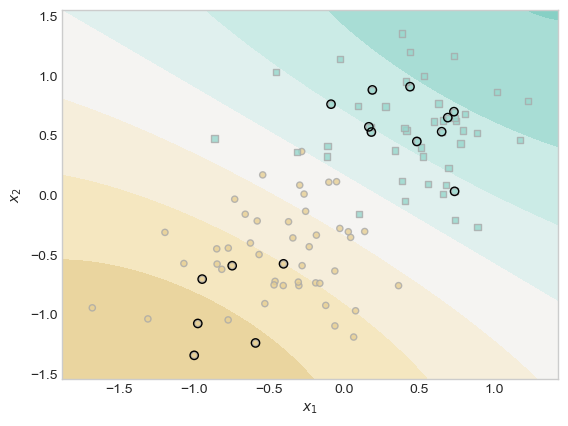

In [36]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

Decision boundaries for a smaller gamma have been compressed and smoothed out although they still retained their approximate size and location for each classification.

# Kernel Methods on Nonlinear Patterns

Lets load a function to generate nonlinear data and test the ideal parameters for kernel regression. 

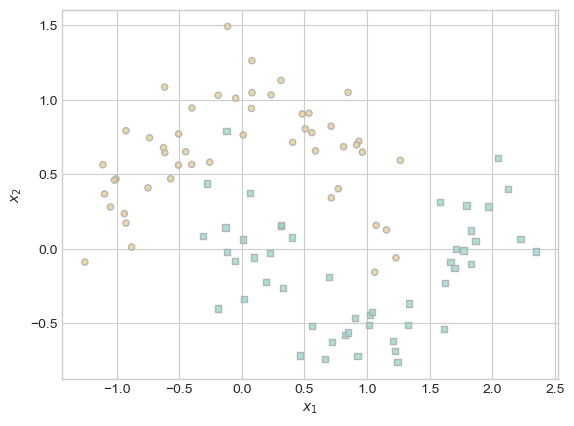

In [52]:
from sklearn.datasets import make_moons

# Generate nonlinear data using the make_moons function from sklearn
X, y = make_moons(n_samples = 100, noise = .2)

# Convert X, y to torch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Plot our nonlinear data
# Generate and plot roughly linearly separable data
fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)

As we can see, our make_moons function has generated two distinct half crescent moons correlated to our two different classes. This is quite starkly nonlinear data. Lets see how kernelized logistic regression performs.

In [ ]:
# instantiate a model with the given kernel and reasonable parameters (higher gamma to allow wiggle)
KR = KernelLogisticRegression(rbf_kernel, lam = .1, gamma = 5)

# Fit the data with 100000 training iterations and a reasonably small alpha
KR.fit(X, y, m_epochs = 100000, alph = 0.001)

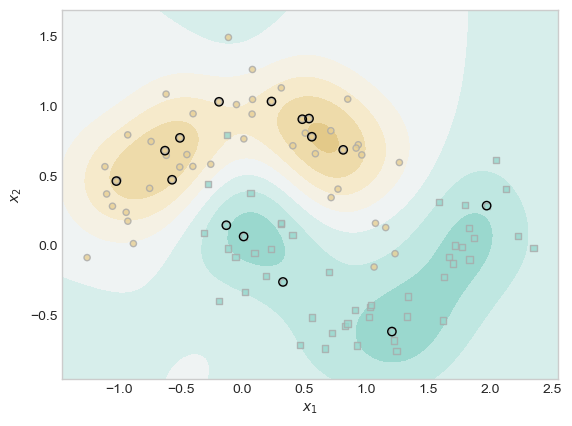

In [ ]:
# plot the decision region and highlight points which have weights distinquishable from zero
ix = torch.abs(KR.a).view(-1) > 1e-4

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")